# import libraries and data

In [1]:
import os
import shutil
import itertools
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
from os import listdir
from os.path import isfile, join, isdir
import matplotlib.pyplot as plt
import seaborn as sns

# helper functions

In [2]:
# Function to create new folder if not exists
def make_new_folder(folder_name, parent_folder_path):
      
    # Path
    path = os.path.join(parent_folder_path, folder_name)
      
    try: 
        
        # mode of the folder
        mode = 0o777
  
        # Create folder
        os.mkdir(path, mode) 
          
    except OSError as error: 
        print(error)

In [3]:
def calc_RMSE(df, epochs, type='train'):
    rmse = []
    for epoch in range(epochs):
        rms = mean_squared_error(df[str(epoch)], df.iloc[:,-1:], squared=False)
        rmse.append(rms)
    return rmse

In [4]:
def merge_folders(onlydir):
    # return if nothing to merge
    if not onlydir:
        return
    
    # merge folders
    current_folder = os.getcwd() 
    
    content_list = []
    for idx, dir in enumerate(onlydir):
        path = os.path.join(file_path, dir)
        content_list.append(os.listdir(path))
        
    # create merged folder name
    merge_folder = onlydir[0][:-7] + "_combined"
    merge_folder_path = os.path.join(current_folder, merge_folder) 
    make_new_folder(merge_folder, os.getcwd())
    
    # move files
    for idx, sub_dir in enumerate(onlydir):
        # loop through the contents of the list of folders
        for contents in content_list[idx]:

            # make the path of the content to move 
            path_to_content = file_path + sub_dir + "/" + contents  

            # make the path with the current folder
            dir_to_move = os.path.join(current_folder, path_to_content )

            # move the file
            shutil.copy(dir_to_move, merge_folder_path)
        
        # delete folder
        # os.rmdir(file_path + sub_dir)

# merge folders

In [5]:
# get list of folders in extracted
file_path = "extracted/"
current_folder = os.getcwd() 
onlydir = [f for f in listdir(file_path) if isdir(join(file_path, f))]
# print(onlydir)

In [6]:
# combine every 4 items in a list
no_parties = 4
onlydir = [onlydir[x:x+no_parties] for x in range(0, len(onlydir), no_parties)]

In [7]:
for aggregation in onlydir:
    if len(aggregation) != no_parties:
        raise exception
    merge_folders(aggregation)

[WinError 183] Cannot create a file when that file already exists: 'C:\\Users\\chanzl_thinkpad\\Desktop\\FATE-Ubuntu\\dc_extracted\\01_08_2021_144404_combined'


# key parameters for a single aggregation

In [8]:
# define where the latest dc_federated results are stored
latest_path = "01_08_2021_025908_combined/"

In [9]:
# define file names
train_name = "_yhat_train_worker_"
test_name = "_yhat_test_worker_"
worker_A = 'A.csv'
worker_B = 'B.csv'
worker_C = 'C.csv'

In [10]:
# get the number of aggregation rounds
onlyfiles = [f for f in listdir(latest_path) if isfile(join(latest_path, f))]
no_aggre = max([int(f.partition('_')[0]) for f in onlyfiles]) - 1
max_aggre = 4  # this is an important hyperparameter

# individual train results

In [11]:
# define how which epoch to take results from for graphing purposes
no_epochs = 4

Worker A final train RMSE: 22.70
Worker B final train RMSE: 37.49
Worker C final train RMSE: 44.70


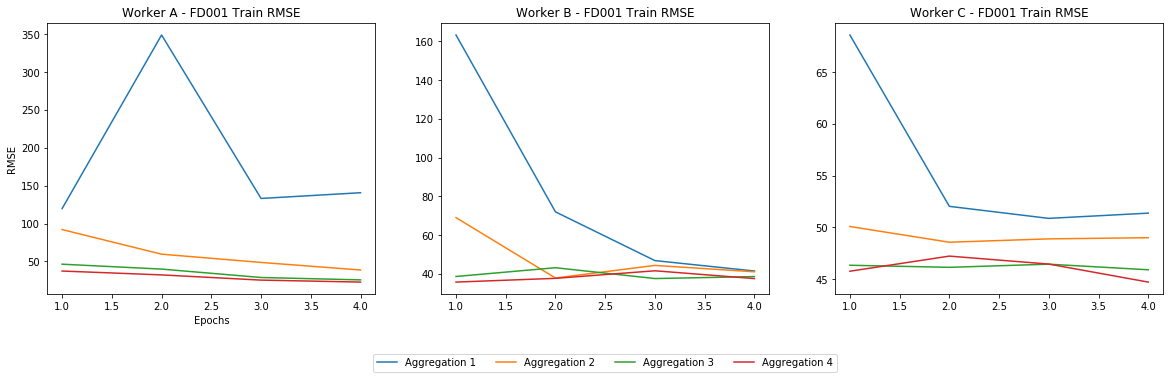

In [12]:
fig, axes = plt.subplots(1, 3, figsize=(20, 5))  # width x height)
rmse_A, rmse_B, rmse_C = 0, 0, 0
for aggre in range(min(no_aggre, max_aggre)):
    aggre += 1
    df_A = pd.read_csv(latest_path + str(aggre) + train_name + worker_A)
    rmse_A = calc_RMSE(df_A, no_epochs)
    axes[0].plot(range(1, len(rmse_A)+1), rmse_A, label="Aggregation "+str(aggre))
    
    df_B = pd.read_csv(latest_path + str(aggre) + train_name + worker_B)
    rmse_B = calc_RMSE(df_B, no_epochs)
    axes[1].plot(range(1, len(rmse_B)+1), rmse_B, label="Aggregation "+str(aggre))
    
    df_C = pd.read_csv(latest_path + str(aggre) + train_name + worker_C)
    rmse_C = calc_RMSE(df_C, no_epochs)
    axes[2].plot(range(1, len(rmse_C)+1), rmse_C, label="Aggregation "+str(aggre))
  
print('Worker A final train RMSE: '+ '{0:.2f}'.format(rmse_A[-1]))  
print('Worker B final train RMSE: '+ '{0:.2f}'.format(rmse_B[-1]))  
print('Worker C final train RMSE: '+ '{0:.2f}'.format(rmse_C[-1]))  

for i in range(3):
    axes[i].title.set_text('Worker ' + chr(65+i) + ' - FD001 Train RMSE') 

axes[1].legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=5)
_ = axes[0].set_xlabel("Epochs")
_ = axes[0].set_ylabel("RMSE")

# individual test results

Worker A final test RMSE: 30.88
Worker B final test RMSE: 29.61
Worker C final test RMSE: 30.58


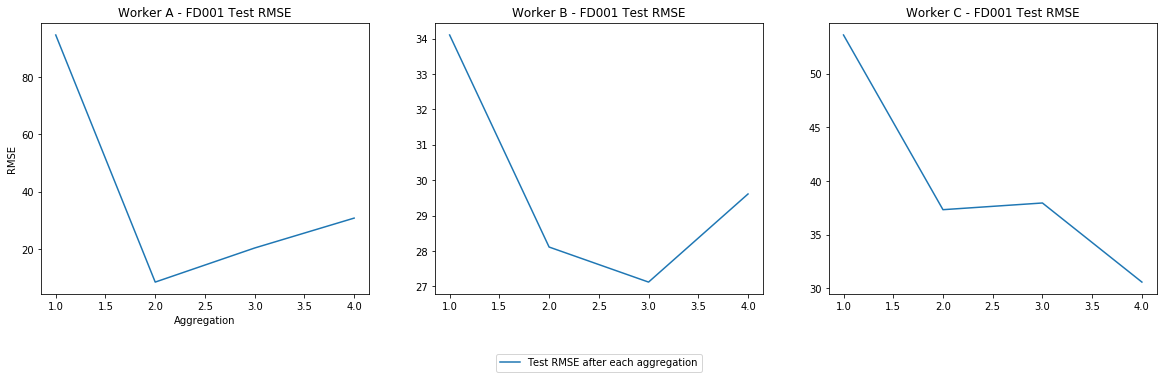

In [13]:
fig, axes = plt.subplots(1, 3, figsize=(20, 5))  # width x height)
rmse_A, rmse_B, rmse_C = 0, 0, 0

for i, worker in enumerate(['A.csv', 'B.csv', 'C.csv']):
    rmse_list = []
    for aggre in range(min(no_aggre, max_aggre)):
        df = pd.read_csv(latest_path + str(aggre+1) + test_name + worker)
        rmse = calc_RMSE(df, 1)
        rmse_list.append(rmse)
    axes[i].plot(range(1, len(rmse_list)+1), rmse_list, label="Test RMSE after each aggregation")
    print('Worker ' + chr(65+i) + ' final test RMSE: '+ '{0:.2f}'.format(rmse_list[-1][0]))

for i in range(3):
    axes[i].title.set_text('Worker ' + chr(65+i) + ' - FD001 Test RMSE')   

axes[1].legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=5)
_ = axes[0].set_xlabel("Aggregation")
_ = axes[0].set_ylabel("RMSE")

# list of all federated results

In [14]:
# get list of folders extracted
onlydir = [f for f in listdir(os.getcwd()) if isdir(join(os.getcwd(), f)) and "combined" in f]
# print(onlydir)

In [15]:
headers = ['id', 'train rmse A', 'train rmse B', 'train rmse C', 
           'test rmse A', 'test rmse B', 'test rmse C', 
           '# test rows A', '# test rows B', '# test rows C','combined test rmse']

In [16]:
content = []
for dir in onlydir:
    temp = [dir]
    latest_path = dir + "/"
    
    # calculate train rmse
    df_A_train = pd.read_csv(latest_path + str(max_aggre) + train_name + worker_A)
    no_epochs = len(df.columns.values) - 2
    temp.append(calc_RMSE(df_A_train, no_epochs)[-1])
    
    df_B_train = pd.read_csv(latest_path + str(max_aggre) + train_name + worker_B)
    temp.append(calc_RMSE(df_B_train, no_epochs)[-1])
    
    df_C_train = pd.read_csv(latest_path + str(max_aggre) + train_name + worker_C)
    temp.append(calc_RMSE(df_C_train, no_epochs)[-1])
     
    # calculate test rmse
    df_A_test = pd.read_csv(latest_path + str(max_aggre) + test_name + worker_A)
    temp.append(calc_RMSE(df_A_test, 1)[-1])
    
    df_B_test = pd.read_csv(latest_path + str(max_aggre) + test_name + worker_B)
    temp.append(calc_RMSE(df_B_test, 1)[-1])
    
    df_C_test = pd.read_csv(latest_path + str(max_aggre) + test_name + worker_C)
    temp.append(calc_RMSE(df_C_test, 1)[-1])   
    
    # add number of rows
    temp.append(len(df_A_test)) 
    temp.append(len(df_B_test)) 
    temp.append(len(df_C_test)) 
    
    # calculate combined rmse
    master = df_A_test.append(df_B_test).append(df_C_test)
    temp.append(calc_RMSE(master, 1)[-1])
        
    content.append(temp)

In [17]:
df_result = pd.DataFrame(content).round(2)
df_result.columns = headers
df_result.sort_values(['combined test rmse'], ascending=[True], inplace=True)
df_result.reset_index(inplace=True, drop=True)
df_result.to_excel("dc_federated_result.xlsx")

In [18]:
# get hyperparameters of top 20 results
print('Federated NN results at the ' + str(max_aggre) + 'th aggregation:')
df_result.head(100)

Federated NN results at the 4th aggregation:


,id,train rmse A,train rmse B,train rmse C,test rmse A,test rmse B,test rmse C,# test rows A,# test rows B,# test rows C,combined test rmse
0,01_08_2021_025908_combined,37.28,35.68,45.75,30.88,29.61,30.58,2,8,594,30.57
1,01_08_2021_022514_combined,37.35,33.13,46.66,13.85,25.84,34.20,2,8,594,34.06
2,01_08_2021_043421_combined,39.65,33.85,46.01,12.31,19.23,35.11,2,8,594,34.90
3,01_08_2021_041034_combined,46.12,37.32,47.72,16.46,24.07,35.14,2,8,594,34.98
4,01_08_2021_032757_combined,38.02,37.58,46.77,12.17,29.59,35.18,2,8,594,35.06
...,...,...,...,...,...,...,...,...,...,...,...
95,01_08_2021_025544_combined,46.20,37.90,48.10,16.06,19.46,44.86,2,8,594,44.55
96,01_08_2021_042929_combined,44.27,37.54,47.98,19.26,16.12,44.88,2,8,594,44.56
97,01_08_2021_034746_combined,45.96,37.86,48.10,14.68,19.57,44.89,2,8,594,44.58
98,01_08_2021_032438_combined,46.61,37.29,48.20,19.06,20.14,44.89,2,8,594,44.59


In [19]:
onlydir = df_result['id'][:20].tolist()
headers = ['id', 'batch_size', 'learn_rate', 'epochs', 'iter_rounds',
           'layer_1', 'layer_2', 'layer_3',]

In [20]:
content = []
for dir in onlydir:
    temp = [dir]
    latest_path = dir + "/"
    
    # append hyperparameters. All 3 parties have the same hyperparameters
    df_A = pd.read_csv(latest_path + '0_worker_A_hyperparamters.csv')
    row = df_A.loc[0].tolist()
    temp = [temp, *row[1:]]          
    content.append(temp)

In [21]:
df_result = pd.DataFrame(content).round(2)
df_result.columns = headers

In [22]:
# edit layer 1, layer 2 and layer 3
df_result['layer_1'] = [f.partition('=') for f in df_result['layer_1']][0][2].partition('=')[2].partition(',')[0]
df_result['layer_2'] = [f.partition('=') for f in df_result['layer_2']][0][2].partition('=')[2].partition(',')[0]
df_result['layer_3'] = [f.partition('=') for f in df_result['layer_3']][0][2].partition('=')[2].partition(',')[0]

In [23]:
df_result.reset_index(inplace=True, drop=True)
df_result.head(20)

,id,batch_size,learn_rate,epochs,iter_rounds,layer_1,layer_2,layer_3
0,[01_08_2021_025908_combined],20,0.06,10,13,128,256,512
1,[01_08_2021_022514_combined],30,0.12,10,15,128,256,512
2,[01_08_2021_043421_combined],20,0.09,10,12,128,256,512
3,[01_08_2021_041034_combined],50,0.08,10,14,128,256,512
4,[01_08_2021_032757_combined],50,0.12,10,7,128,256,512
5,[01_08_2021_042833_combined],30,0.06,10,7,128,256,512
6,[01_08_2021_030035_combined],50,0.10,10,9,128,256,512
7,[01_08_2021_032149_combined],35,0.06,10,8,128,256,512
8,[01_08_2021_034922_combined],30,0.08,10,7,128,256,512
9,[01_08_2021_025705_combined],30,0.08,10,5,128,256,512
